In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
file_path = "mdi_homicidios_intencionales_pm_2014_2024.xlsx"
df = pd.read_excel(file_path, sheet_name="1", header=1, usecols=lambda col: col != "Unnamed: 0")
df_para_visualizar = df.copy()

## **Preprocesamiento de datos**
### **Limpieza de datos**

In [3]:
df = df.replace(["SIN_DATO", "NO DETERMINADO", "NO DETERMINADA", "NO APLICA"], np.nan)
df_para_visualizar = df_para_visualizar.replace(["SIN_DATO", "NO DETERMINADO", "NO DETERMINADA", "NO APLICA"], np.nan)
df = df.dropna(subset=["presunta_motivacion"])
df_para_visualizar = df_para_visualizar.dropna(subset=["genero"])

cols_to_drop = ["codigo_subcircuito", "codigo_provincia", "codigo_canton", "profesion_registro_civil"]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

df["hora_infraccion"] = pd.to_datetime(df["hora_infraccion"], errors="coerce").dt.hour

df["fecha_infraccion"] = pd.to_datetime(df["fecha_infraccion"], errors="coerce")
df["anio_infraccion"] = df["fecha_infraccion"].dt.year
df["mes_infraccion"] = df["fecha_infraccion"].dt.month
df["dia_semana"] = df["fecha_infraccion"].dt.dayofweek

df.drop(columns=["fecha_infraccion"], inplace=True)

df["edad"] = pd.to_numeric(df["edad"], errors="coerce")

df = df.dropna(thresh=len(df.columns) - 5)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27776\433593272.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(["SIN_DATO", "NO DETERMINADO", "NO DETERMINADA", "NO APLICA"], np.nan)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27776\433593272.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_para_visualizar = df_para_visualizar.replace(["SIN_DATO", "NO DETERMINADO", "NO DETERMINADA", "NO APLICA"], np.nan)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27776\433593272.py:9: UserWarning: Could not infer format, 

### **Normalización de datos**

In [4]:
target_le = LabelEncoder()
df["presunta_motivacion_encoded"] = target_le.fit_transform(df["presunta_motivacion"].astype(str))
y = df["presunta_motivacion_encoded"]
df.drop(columns=["presunta_motivacion"], inplace=True)

In [5]:
#codificación de variables categóricas con un encoder por columna
categorical_cols = df.select_dtypes(include='object').columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

In [6]:
#normalización de variables numéricas
X = df.drop(columns=["presunta_motivacion_encoded"])
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(df[numeric_cols])


## **Análisis Exploratorio de Datos (EDA)**
### **Estadísticas descriptivas**

In [7]:
print("Resumen de estadísticas descriptivas:")
df_para_visualizar.describe()

Resumen de estadísticas descriptivas:


codigo_provincia  codigo_canton               fecha_infraccion  \
count      24007.000000   24007.000000                          24007   
mean          10.820219    1086.429958  2023-03-22 18:02:33.855125504   
min            1.000000     101.000000            2019-09-06 00:00:00   
25%            9.000000     901.000000            2022-06-18 00:00:00   
50%            9.000000     907.000000            2023-06-08 00:00:00   
75%           13.000000    1301.000000            2024-03-07 12:00:00   
max           24.000000    2403.000000            2024-12-31 00:00:00   
std            4.458348     445.376046                            NaN   

               edad  
count  23530.000000  
mean      32.527199  
min        0.000000  
25%       24.000000  
50%       30.000000  
75%       39.000000  
max       98.000000  
std       12.000802

In [8]:
#descripción de variables numéricas (incluyendo aquellas que fueron normalizadas y/o codificadas)
print("Resumen estadístico:")
df.describe()

Resumen estadístico:


tipo_muerte          zona       subzona      distrito      circuito  \
count  30234.000000  30234.000000  30234.000000  30234.000000  30234.000000   
mean       0.245915      4.741946     10.179500     78.878217    514.705001   
std        0.653582      2.358801      5.247359     42.437216    292.973643   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      3.000000      6.000000     43.000000    267.000000   
50%        0.000000      4.000000      8.000000     77.000000    519.000000   
75%        0.000000      7.000000     14.000000    111.000000    776.000000   
max        3.000000      8.000000     25.000000    163.000000   1005.000000   

       codigo subcircuito   subcircuito     provincia        canton  \
count        30234.000000  30234.000000  30234.000000  30234.000000   
mean           764.605610    906.894787     12.153767    101.101806   
std            415.772254    509.580316      5.298206     50.688655   
min              0.000000      0.000000      0.000000      0.000000   
25%            438.000000    485.000000     10.000000     78.000000   
50%            684.000000    903.000000     10.000000     78.000000   
75%           1004.000000   1358.000000     15.000000    148.000000   
max           1716.000000   1733.000000     28.000000    217.000000   

       coordenada_y  ...         etnia  estado_civil  nacionalidad  \
count  30234.000000  ...  30234.000000  30234.000000  30234.000000   
mean   10654.889958  ...      4.700205      2.717570     17.729874   
std     5047.146615  ...      1.590214      1.198756      3.708256   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%     6434.250000  ...      5.000000      3.000000     17.000000   
50%    12218.500000  ...      5.000000      3.000000     17.000000   
75%    15248.000000  ...      5.000000      3.000000     17.000000   
max    17186.000000  ...      9.000000      5.000000     35.000000   

       discapacidad   instruccion  antecedentes  anio_infraccion  \
count  30234.000000  30234.000000  30234.000000     30234.000000   
mean       4.066382      7.172091      0.479857      2021.373255   
std        0.551210      3.237976      0.710041         2.888350   
min        0.000000      0.000000      0.000000      2014.000000   
25%        4.000000      6.000000      0.000000      2020.000000   
50%        4.000000      9.000000      0.000000      2023.000000   
75%        4.000000      9.000000      1.000000      2023.000000   
max        7.000000      9.000000      2.000000      2024.000000   

       mes_infraccion    dia_semana  presunta_motivacion_encoded  
count    30234.000000  30234.000000                 30234.000000  
mean         6.820269      3.288053                     1.004862  
std          3.432560      2.065369                     1.793496  
min          1.000000      0.000000                     0.000000  
25%          4.000000      1.000000                     0.000000  
50%          7.000000      3.000000                     0.000000  
75%         10.000000      5.000000                     0.000000  
max         12.000000      6.000000                     6.000000  

[8 rows x 33 columns]

In [9]:
#descripción de variables categóricas
df_para_visualizar.describe(include='object')

tipo_muerte    zona         subzona          distrito       circuito  \
count        24007   24007           24007             24007          24007   
unique           4       9              26               162            933   
top      ASESINATO  ZONA 8  D.M. GUAYAQUIL  NUEVA PROSPERINA  SAN FRANCISCO   
freq         21653    8273            8273              1447            522   

       codigo subcircuito      subcircuito provincia     canton coordenada_y  \
count               24007            24007     24007      24007        24007   
unique               1555             1599        29        205        12590   
top           09D07C07S02  SAN FRANCISCO 2    GUAYAS  GUAYAQUIL            0   
freq                  465              465     10839       6964         7851   

        ... medida_edad    sexo     genero      etnia estado_civil  \
count   ...       23530   23991      24007      23231        21664   
unique  ...           1       2          6          9            5   
top     ...           A  HOMBRE  MASCULINO  MESTIZO/A      SOLTERO   
freq    ...       23530   22040      22018      20362        18104   

       nacionalidad discapacidad profesion_registro_civil instruccion  \
count         23227        23987                    20715        4098   
unique           27            7                      322           9   
top         ECUADOR      NINGUNA               ESTUDIANTE      BASICA   
freq          22158        23654                     9412        1654   

       antecedentes  
count         22543  
unique            2  
top              NO  
freq          16652  

[4 rows x 30 columns]

In [10]:
#frecuencia de clases por variable categórica
for col in df_para_visualizar.select_dtypes(include='object').columns:
    print(f"\nFrecuencia de clases en '{col}':\n{df_para_visualizar[col].value_counts()}")


Frecuencia de clases en 'tipo_muerte':
tipo_muerte
ASESINATO    21653
HOMICIDIO     1782
FEMICIDIO      429
SICARIATO      143
Name: count, dtype: int64

Frecuencia de clases en 'zona':
zona
ZONA 8    8273
ZONA 5    5830
ZONA 4    3251
ZONA 1    2066
ZONA 7    1847
ZONA 9    1049
ZONA 6     831
ZONA 3     478
ZONA 2     382
Name: count, dtype: int64

Frecuencia de clases en 'subzona':
subzona
D.M. GUAYAQUIL              8273
MANABI                      2709
GUAYAS                      2566
LOS RIOS                    2555
EL ORO                      1703
ESMERALDAS                  1503
D.M. QUITO                  1049
SANTA ELENA                  619
STO DGO DE LOS TSACHILAS     542
CAÑAR                        437
SUCUMBIOS                    401
AZUAY                        315
ORELLANA                     205
TUNGURAHUA                   172
COTOPAXI                     171
PICHINCHA                    123
IMBABURA                     117
LOJA                         112
BOLIVAR  

### **Visualización de datos**

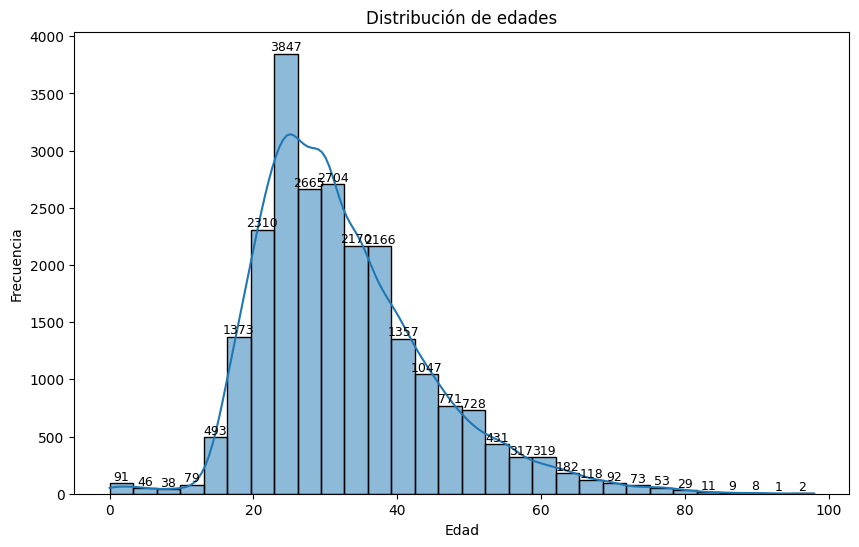

In [11]:
plt.figure(figsize=(10, 6))
edmx = sns.histplot(df_para_visualizar['edad'], kde=True, bins=30)
plt.title("Distribución de edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")

for p in edmx.patches:
    height = p.get_height()
    edmx.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.show()

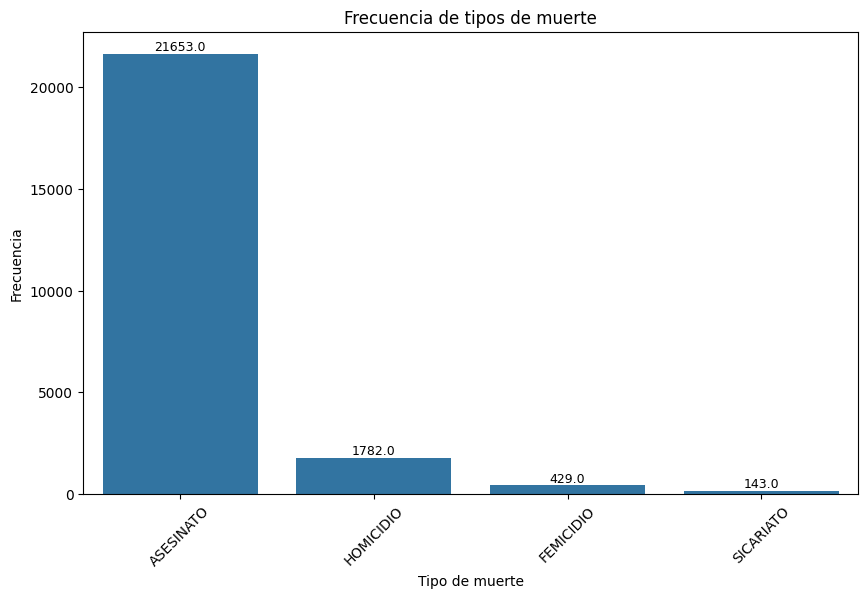

In [12]:
plt.figure(figsize=(10, 6))
tmx = sns.countplot(data=df_para_visualizar, x='tipo_muerte', order=df_para_visualizar['tipo_muerte'].value_counts().index)
plt.title("Frecuencia de tipos de muerte")
plt.xticks(rotation=45)
plt.xlabel("Tipo de muerte")
plt.ylabel("Frecuencia")

for p in tmx.patches:
    height = p.get_height()
    tmx.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.show()

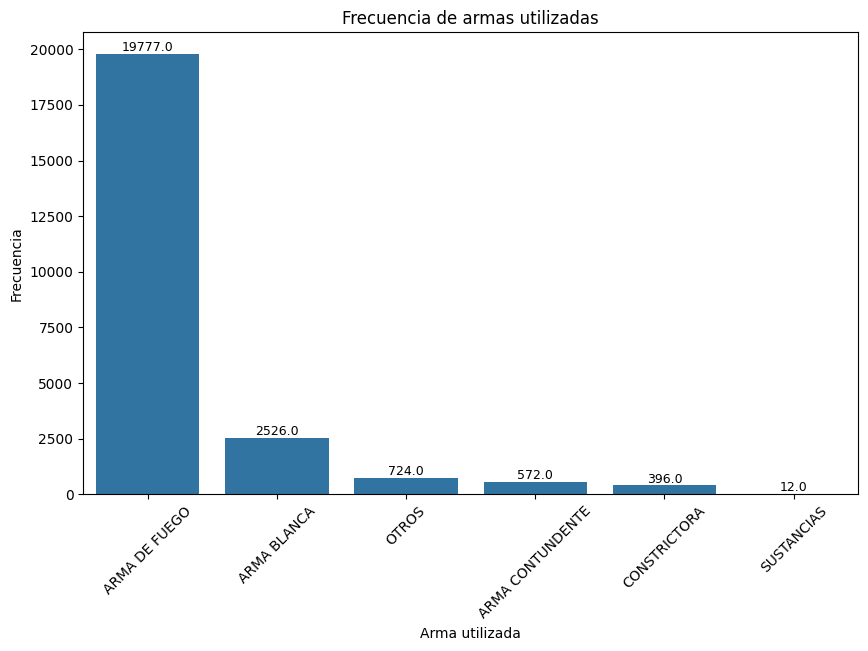

In [13]:
#gráfico de barras para armas utilizadas
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_para_visualizar, x='arma', order=df_para_visualizar['arma'].value_counts().index)
plt.title("Frecuencia de armas utilizadas")
plt.xticks(rotation=45)
plt.xlabel("Arma utilizada")
plt.ylabel("Frecuencia")

#mostrar los valores encima de las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.show()

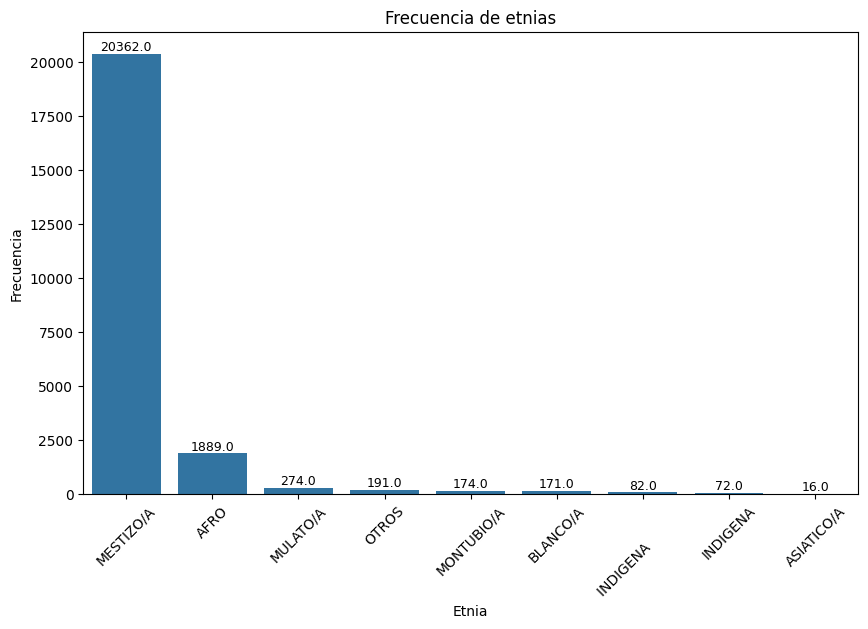

In [14]:
#gráfico de barras para distribución por etnia
plt.figure(figsize=(10, 6))
ex = sns.countplot(data=df_para_visualizar, x='etnia', order=df_para_visualizar['etnia'].value_counts().index)
plt.title("Frecuencia de etnias")
plt.xticks(rotation=45)
plt.xlabel("Etnia")
plt.ylabel("Frecuencia")

for p in ex.patches:
    height = p.get_height()
    ex.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.show()

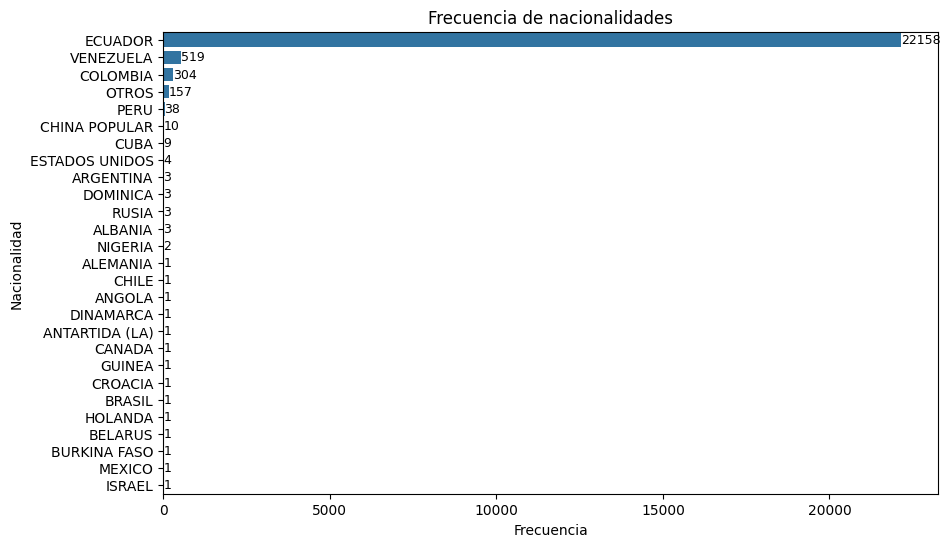

In [15]:
plt.figure(figsize=(10, 6))
ny = sns.countplot(data=df_para_visualizar, y='nacionalidad', order=df_para_visualizar['nacionalidad'].value_counts().index)
plt.title("Frecuencia de nacionalidades")
plt.ylabel("Nacionalidad")
plt.xlabel("Frecuencia")

for p in ny.patches:
    width = p.get_width()
    ny.annotate(f'{int(width)}', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=9, color='black')

plt.show()


In [16]:
import plotly.express as px

fig = px.pie(
    df_para_visualizar,
    names='genero',
    title='Distribución de géneros de las víctimas',
    color='genero',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.update_traces(
    textinfo='percent+label',
    pull=[0.05 if g == 'FEMENINO' else 0 for g in df_para_visualizar['genero'].unique()],
    marker=dict(line=dict(color='#FFFFFF', width=2)),
    rotation=90,
    hole=0.3
)
fig.update_layout(
    title_font_size=22,
    legend_title_text='Género',
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,
        font=dict(size=14)
    ),
    margin=dict(t=60, b=20, l=20, r=120)
)
fig.show()


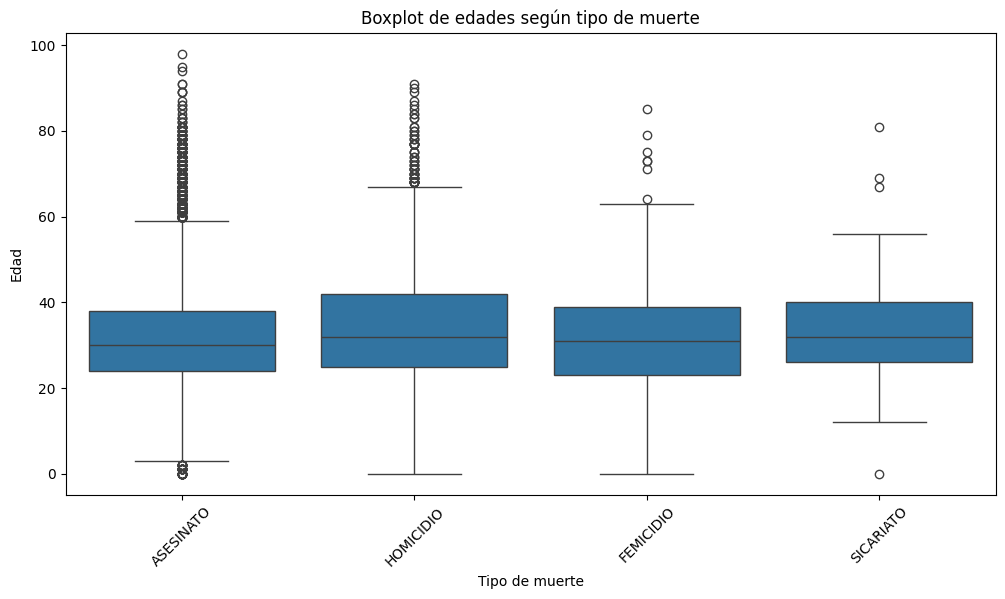

In [17]:
#boxplot para edades según tipo de muerte
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_para_visualizar, x='tipo_muerte', y='edad')
plt.title("Boxplot de edades según tipo de muerte")
plt.xlabel("Tipo de muerte")
plt.ylabel("Edad")
plt.xticks(rotation=45)
plt.show()

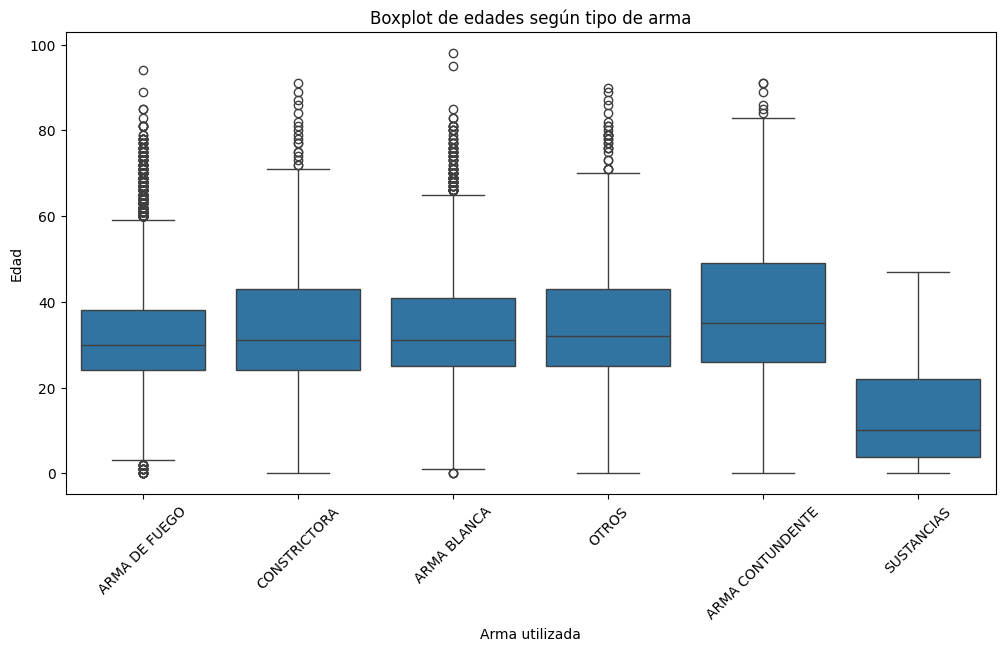

In [18]:
#bloxplot para edades según tipo de arma
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_para_visualizar, x='arma', y='edad')
plt.title("Boxplot de edades según tipo de arma")
plt.xlabel("Arma utilizada")
plt.ylabel("Edad")
plt.xticks(rotation=45)
plt.show()

### **Detección de patrones y relevantes**

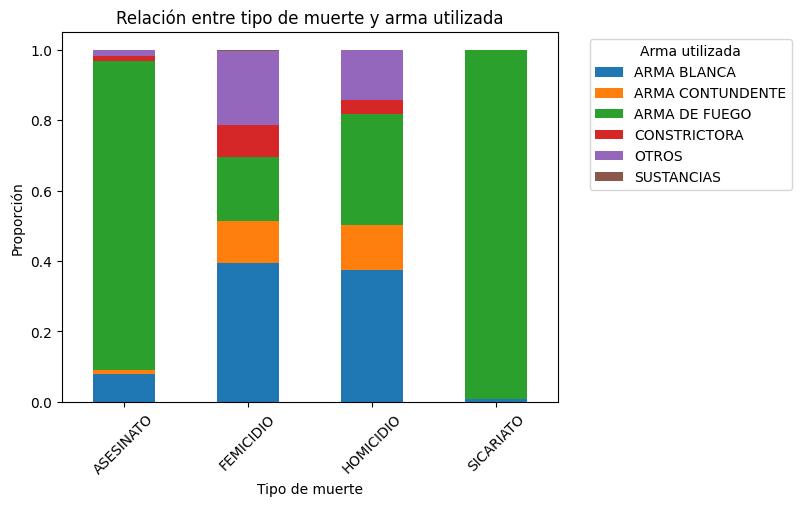

In [19]:
#relación entre tipo de muerte y arma
pd.crosstab(df_para_visualizar['tipo_muerte'], df_para_visualizar['arma'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Relación entre tipo de muerte y arma utilizada")
plt.xlabel("Tipo de muerte")
plt.ylabel("Proporción")
plt.xticks(rotation=45)
plt.legend(title='Arma utilizada', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

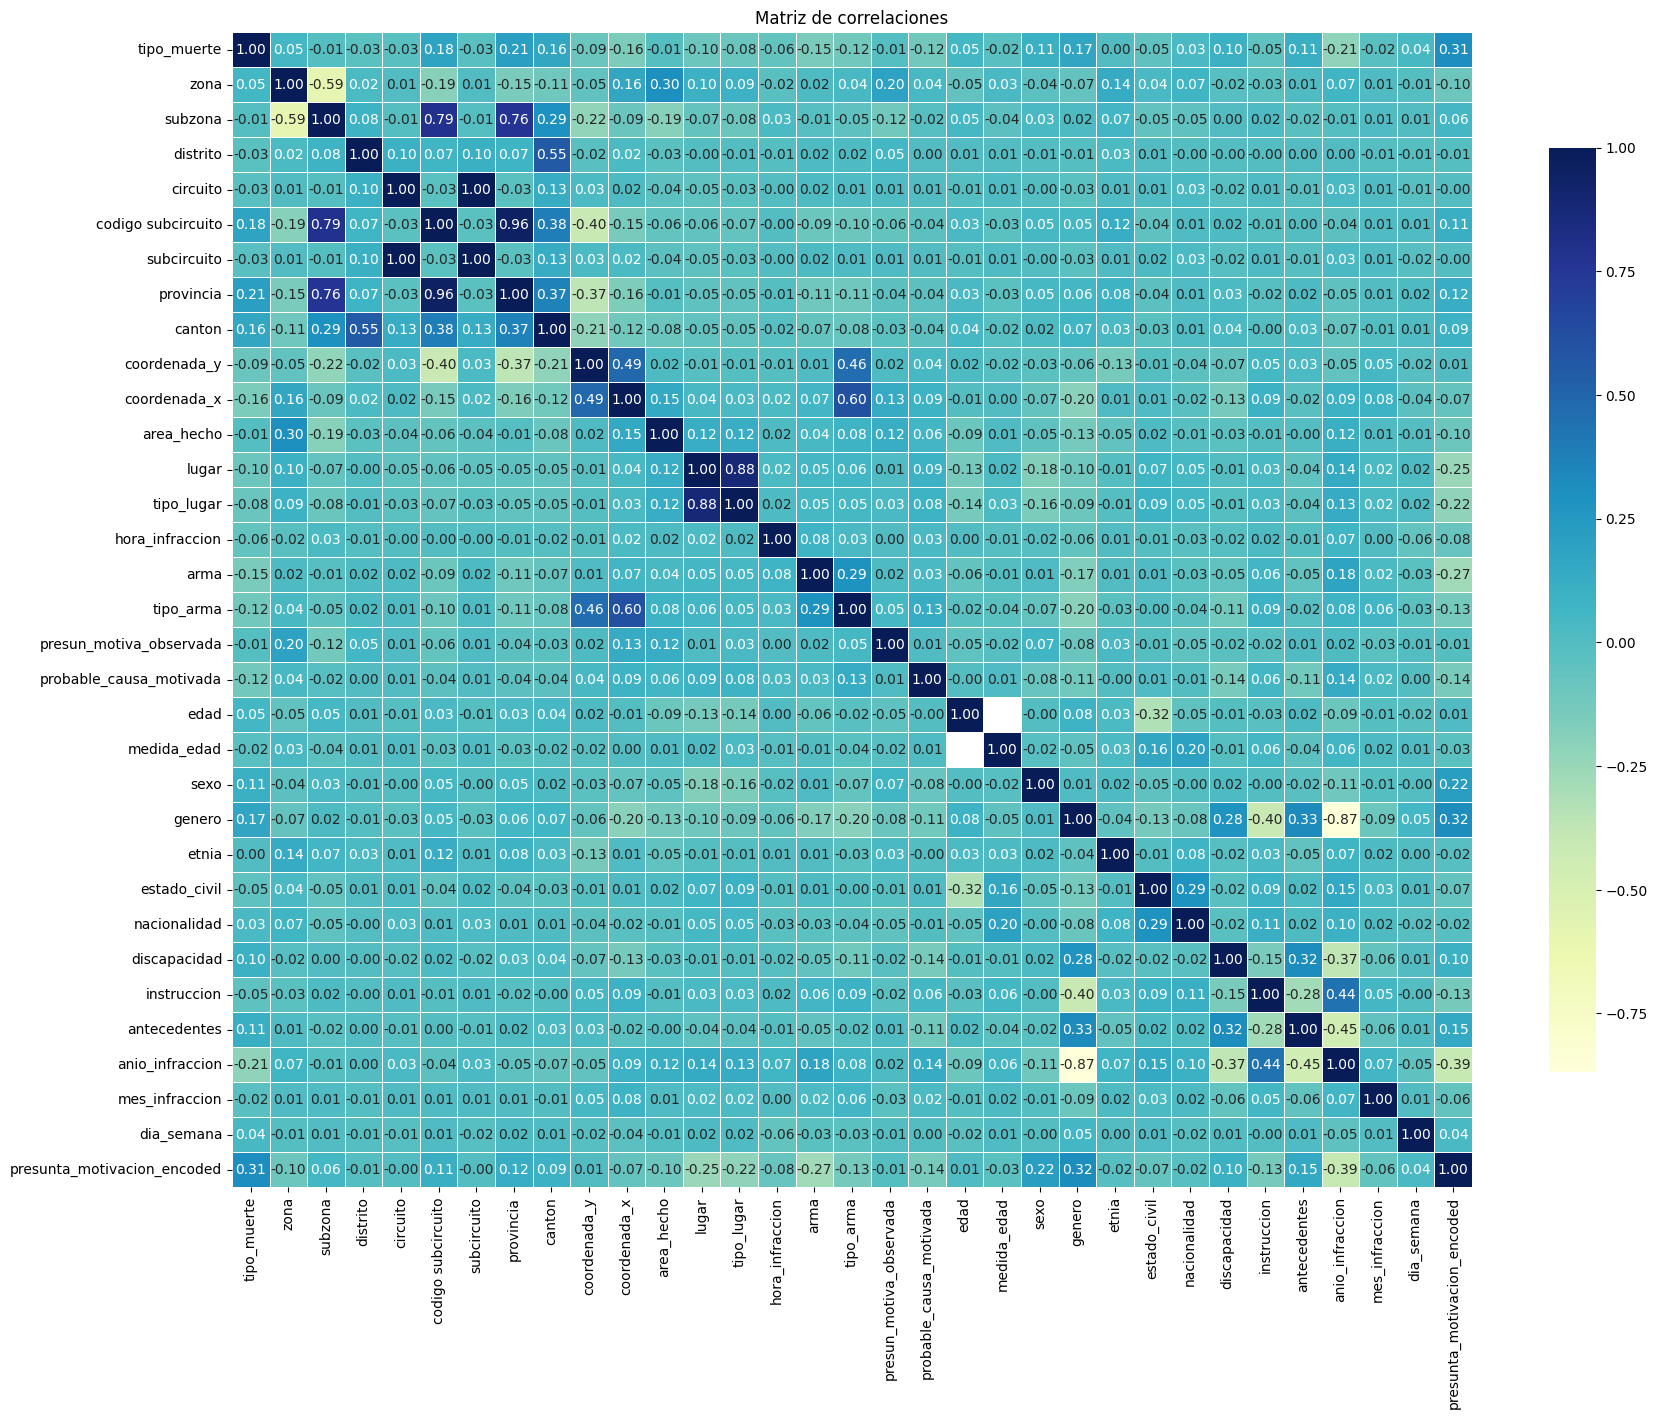

In [20]:
#correlación
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt=".2f", linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Matriz de correlaciones")
plt.show()


## **Aplicación de técnicas de Minería de datos**

### **Entrenamiento**

**Árbol de Decisión**

In [21]:
#dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
#clases del conjunto completo
print("Distribución de clases en el conjunto completo:")
print(pd.Series(y).value_counts().sort_index())

Distribución de clases en el conjunto completo:
presunta_motivacion_encoded
0    22871
1       41
2       45
3      378
4     5424
5     1430
6       45
Name: count, dtype: int64


In [23]:
#clases del conjunto de entrenamiento
print("\nDistribución de clases en entrenamiento:")
print(pd.Series(y_train).value_counts().sort_index())


Distribución de clases en entrenamiento:
presunta_motivacion_encoded
0    18264
1       31
2       36
3      311
4     4332
5     1176
6       37
Name: count, dtype: int64


In [24]:
#clases del conjunto de prueba
print("\nDistribución de clases en prueba:")
print(pd.Series(y_test).value_counts().sort_index())


Distribución de clases en prueba:
presunta_motivacion_encoded
0    4607
1      10
2       9
3      67
4    1092
5     254
6       8
Name: count, dtype: int64


In [25]:
#entrenamiento del modelo de árbol de decisión
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


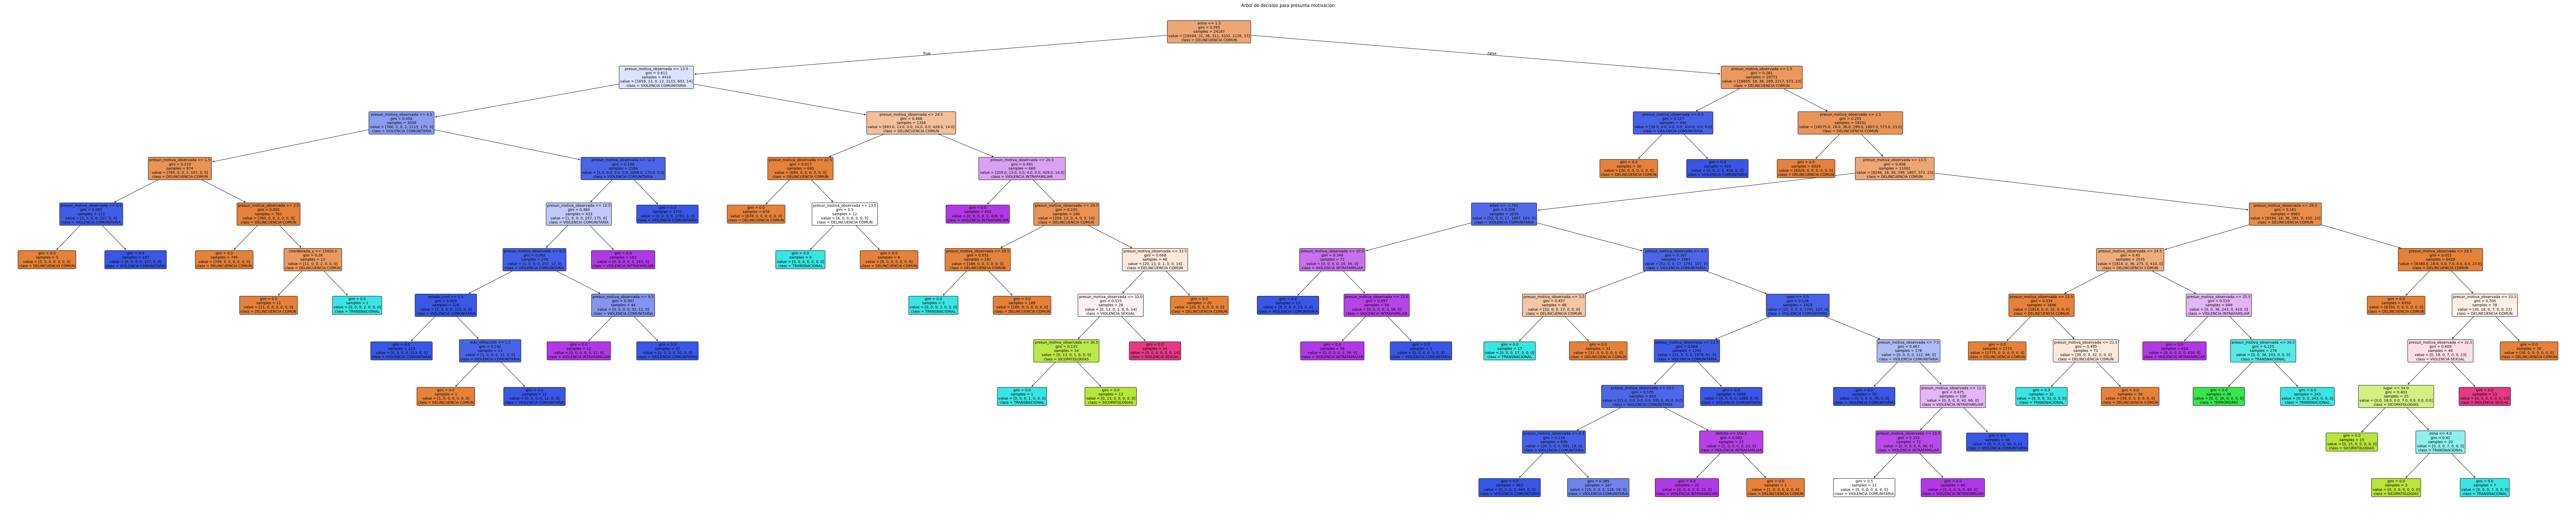

In [26]:
plt.figure(figsize=(100, 20))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=target_le.classes_,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=10  #limitar la profundidad del árbol para una mejor visualización
)
plt.title("Árbol de decisión para presunta motivación")
plt.tight_layout()
plt.show()

**DBSCAN**

In [27]:
#preparación de datos para DBSCAN
dbscan_features = ["edad", "hora_infraccion", "tipo_arma", "zona", "sexo"]
dbscan_data = X[dbscan_features].dropna().copy()

dbscan_data_encoded = pd.get_dummies(dbscan_data, columns=["tipo_arma", "zona", "sexo"])
scaler_dbscan = StandardScaler()

dbscan_scaled = scaler_dbscan.fit_transform(dbscan_data_encoded)


In [28]:
#aplicación de DBSCAN
db = DBSCAN(eps=1.5, min_samples=10).fit(dbscan_data) # eps es el radio de búsqueda y min_samples es el número mínimo de puntos para formar un cluster
dbscan_labels = db.labels_


### **Validación**

**Árbol de decisión**

In [29]:
#reporte de clasificación
print("\nReporte de clasificación (árbol de decisión):")
print(classification_report(y_test, y_pred, zero_division=0))


Reporte de clasificación (árbol de decisión):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4607
           1       0.91      1.00      0.95        10
           2       1.00      1.00      1.00         9
           3       1.00      0.99      0.99        67
           4       0.99      1.00      0.99      1092
           5       0.99      0.97      0.98       254
           6       1.00      1.00      1.00         8

    accuracy                           1.00      6047
   macro avg       0.98      0.99      0.99      6047
weighted avg       1.00      1.00      1.00      6047



In [30]:
#clases que están siendo predichas
print(f"\nClases únicas en y_test: {np.unique(y_test)}")
print(f"Clases únicas en y_pred: {np.unique(y_pred)}")
print(f"Clases no predichas: {set(np.unique(y_test)) - set(np.unique(y_pred))}")


Clases únicas en y_test: [0 1 2 3 4 5 6]
Clases únicas en y_pred: [0 1 2 3 4 5 6]
Clases no predichas: set()


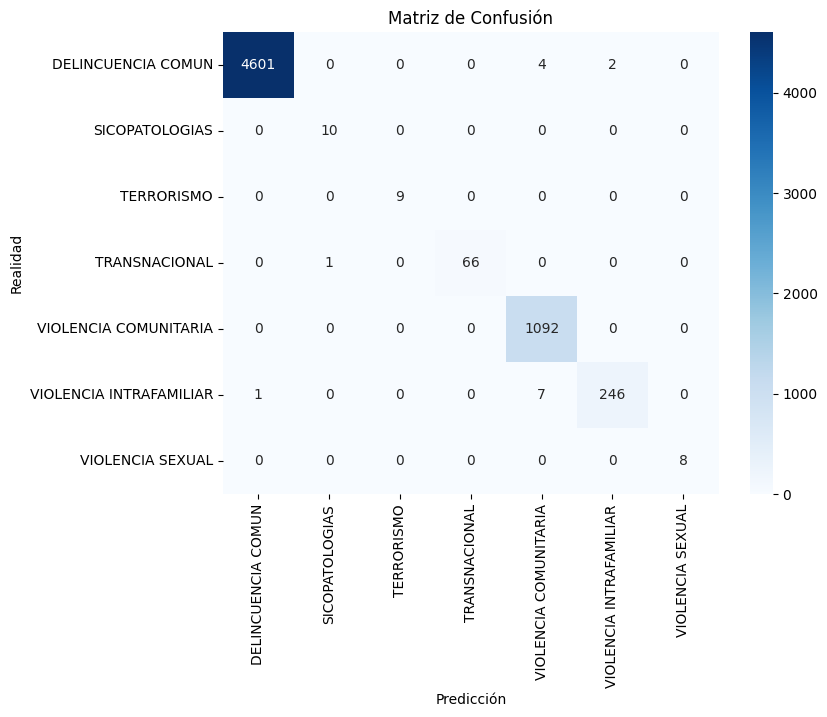

In [31]:
#matriz de confusión del modelo
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_le.classes_, yticklabels=target_le.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

In [32]:
#validación cruzada con F1-score
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5, scoring='f1_weighted')
print(f"F1-score promedio con validación cruzada: {scores.mean():.4f}")

#recall
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"Recall promedio: {recall:.4f}")

#precision
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"Precision promedio: {precision:.4f}")


F1-score promedio con validación cruzada: 0.7201
Recall promedio: 0.9975
Precision promedio: 0.9975


**DBSCAN**

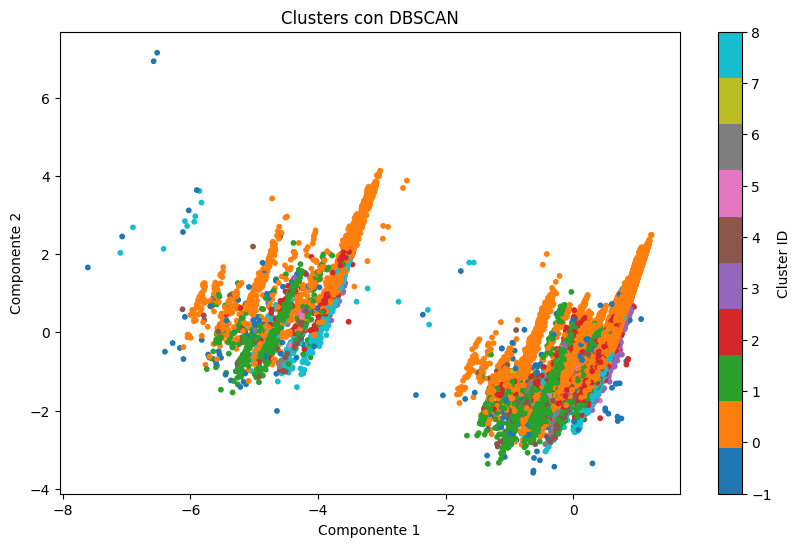

In [33]:
#reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
db_2d = pca.fit_transform(dbscan_scaled)

plt.figure(figsize=(10,6))
plt.scatter(db_2d[:, 0], db_2d[:, 1], c=dbscan_labels, cmap='tab10', s=10)
plt.title("Clusters con DBSCAN")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(label='Cluster ID')
plt.show()

In [34]:
from sklearn.metrics import silhouette_score

score = silhouette_score(dbscan_data, dbscan_labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.4706073925723101


In [35]:
#calcular el índice de Davies-Bouldin
#rango de 0 a infinito, valores más bajos indican mejor separación entre clusters
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(dbscan_data, dbscan_labels)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 3.1905560005119344


In [36]:
#calcular el índice de Calinski-Harabasz
#rango de 0 a infinito, valores más altos indican clusters más compactos y bien separados
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(dbscan_data, dbscan_labels)
print(f"Calinski-Harabasz Score: {ch_score}")

Calinski-Harabasz Score: 43207.47421604455


In [37]:
df_dbscan = df.loc[dbscan_data.index].copy()
df_dbscan["cluster"] = dbscan_labels

# tipo de arma por cluster
pd.crosstab(df_dbscan["cluster"], df_dbscan["tipo_arma"], normalize='index') * 100

tipo_arma        0         1         2         3         4         5   \
cluster                                                                 
-1         0.398406  2.390438  0.398406  1.195219  5.976096  1.593625   
 0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 3         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 4         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 5         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 6         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 7         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 8         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

tipo_arma        6          7         8         9   ...      53         54  \
cluster                                             ...                      
-1         0.398406  13.944223  0.796813  1.992032  ...  0.0000   0.000000   
 0         0.000000   0.000000  0.000000  0.000000  ...  0.0000   0.000000   
 1         0.000000   0.000000  0.000000  0.320770  ...  0.0000   0.000000   
 2         0.000000   0.000000  0.000000  0.000000  ...  0.6917  43.873518   
 3         0.000000   0.000000  0.000000  0.000000  ...  0.0000   0.000000   
 4         0.000000   0.000000  0.000000  0.000000  ...  0.0000   0.000000   
 5         0.000000   0.000000  0.000000  0.000000  ...  0.0000   0.000000   
 6         0.000000   0.000000  0.000000  0.000000  ...  0.0000   0.000000   
 7         0.000000   0.000000  0.000000  0.000000  ...  0.0000   0.000000   
 8         0.000000   0.000000  0.000000  0.000000  ...  0.0000   0.000000   

tipo_arma         55        56        57        58        59        60  \
cluster                                                                  
-1          0.796813  0.796813  3.984064  1.593625  2.390438  1.992032   
 0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 1          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2         42.786561  4.644269  5.237154  1.877470  0.592885  0.098814   
 3          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 4          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 5          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 6          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 7          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 8          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

tipo_arma        61         62  
cluster                         
-1         0.000000   0.000000  
 0         0.000000   0.000000  
 1         0.000000   0.000000  
 2         0.000000   0.000000  
 3         0.000000   0.000000  
 4         0.000000   0.000000  
 5         0.000000   0.000000  
 6         0.000000   0.000000  
 7         0.000000   0.000000  
 8         0.150683  99.849317  

[10 rows x 63 columns]

In [38]:
pd.crosstab(df_dbscan["cluster"], df_dbscan["zona"], normalize='index') * 100

zona             0          1          2          3          4         5  \
cluster                                                                    
-1       14.342629   7.968127  10.756972  10.756972   7.171315  8.366534   
 0        7.658120   1.593162   1.620513  13.018803  24.984615  2.495726   
 1       14.675221   4.891740   6.174820  10.184443  16.198877  5.854050   
 2       11.462451   2.025692   2.223320  15.069170  35.424901  4.100791   
 3       12.897822   3.517588   0.335008  19.262982  28.140704  6.030151   
 4       24.335378   4.703476   4.294479  16.768916  25.562372  6.339468   
 5        0.000000   0.000000   0.000000  44.897959  44.897959  6.122449   
 6       86.666667  13.333333   0.000000   0.000000   0.000000  0.000000   
 7        0.000000   8.333333  12.500000  33.333333  37.500000  8.333333   
 8       10.063502   1.474545   3.024432  13.378538  20.708212  4.800344   

zona             6          7          8  
cluster                                   
-1       11.155378  14.741036  14.741036  
 0        8.205128  36.642735   3.781197  
 1        6.896552  12.910986  22.213312  
 2        7.855731  18.379447   3.458498  
 3       14.405360  12.730318   2.680067  
 4        6.952965   9.202454   1.840491  
 5        4.081633   0.000000   0.000000  
 6        0.000000   0.000000   0.000000  
 7        0.000000   0.000000   0.000000  
 8        6.683888  34.183619   5.682919

In [39]:
noise_ratio = np.sum(dbscan_labels == -1) / len(dbscan_labels)
print(f"Porcentaje de datos considerados ruido: {noise_ratio * 100:.2f}%")

Porcentaje de datos considerados ruido: 0.84%


### **Prueba**

In [40]:
idx = 200

#print("\nValores originales")
#print(df.loc[X.index[idx]])

pred_encoded = clf.predict(X.iloc[idx].values.reshape(1, -1))

pred_label = target_le.inverse_transform(pred_encoded)

print(f"Predicción (presunta motivación): {pred_label[0]}")

true_encoded = y.iloc[idx]
true_label = target_le.inverse_transform([true_encoded])
print(f"Valor real (presunta motivación): {true_label[0]}")

Predicción (presunta motivación): TRANSNACIONAL
Valor real (presunta motivación): TRANSNACIONAL


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [41]:
# Crear un nuevo registro usando el encoder correcto para cada columna
new = pd.DataFrame([{
    "tipo_muerte": encoders["tipo_muerte"].transform(["HOMICIDIO"])[0],
    "zona": encoders["zona"].transform(["ZONA 9"])[0],
    "subzona": encoders["subzona"].transform(["D.M. QUITO"])[0],
    "distrito": encoders["distrito"].transform(["ELOY ALFARO - DMQ"])[0],
    "circuito": encoders["circuito"].transform(["FERROVIARIA"])[0],
    "subcircuito": encoders["subcircuito"].transform(["FERROVIARIA 1"])[0],
    "provincia": encoders["provincia"].transform(["PICHINCHA"])[0],
    "canton": encoders["canton"].transform(["QUITO"])[0],
    "coordenada_y": -0.25918,
    "coordenada_x": -78.51604,
    "area_hecho": encoders["area_hecho"].transform(["URBANO"])[0],
    "lugar": encoders["lugar"].transform(["CASA/VILLA"])[0],
    "tipo_lugar": encoders["tipo_lugar"].transform(["PRIVADO"])[0],
    "hora_infraccion": pd.to_datetime("00:10:00", errors="coerce").hour,
    "arma": encoders["arma"].transform(["ARMA BLANCA"])[0],
    "tipo_arma": encoders["tipo_arma"].transform(["CUCHILLO"])[0],
    "presunta_motivacion": "DELINCUENCA COMUN",
    "presun_motiva_observada": encoders["presun_motiva_observada"].transform(["AMENAZA"])[0],
    "probable_causa_motivada": encoders["probable_causa_motivada"].transform(["HERIDA POR ARMA BLANCA"])[0],
    "edad": 19,
    "medida_edad": encoders["medida_edad"].transform(["A"])[0],
    "sexo": encoders["sexo"].transform(["HOMBRE"])[0],
    "genero": encoders["genero"].transform(["MASCULINO"])[0],
    "etnia": np.nan, # no hay dato, se asume que no se tiene información
    "estado_civil": encoders["estado_civil"].transform(["SOLTERO"])[0],
    "nacionalidad": encoders["nacionalidad"].transform(["ECUADOR"])[0],
    "discapacidad": encoders["discapacidad"].transform(["NINGUNA"])[0],
    "instruccion": np.nan, # no hay dato, se asume que no se tiene información
    "antecedentes": encoders["antecedentes"].transform(["NO"])[0],
    "anio_infraccion": 2025,
    "mes_infraccion": 1,
    "dia_semana": 1,
}])
true_value = new["presunta_motivacion"]
new.drop(columns=["presunta_motivacion"], inplace=True)

new[numeric_cols] = scaler.transform(new[numeric_cols])

pred_encoded = clf.predict(new)
pred_label = target_le.inverse_transform(pred_encoded)

print("\nPredicción de la nueva instancia:", pred_label[0])
print("Valor real:", true_value.values[0])

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- codigo subcircuito
